# 1. Motivation

### What is your dataset?

The dataset we will be analysing is a collection of songs, each with the artists that worked on them, the lyrics, and the release date.

The network will be created with each artist as a node and the links will be if the artists have collaborated on a song.

The text analysis will be conducted on the lyrics of all the songs gathered.

### Why did you choose this dataset?

Musicians tend to collaborate together, which we thought would make for an interesting network. Furthermore, investigating the different artists language through their song lyrics to find patterns and attributes would be fun.

### What was your goal for the end user's experience?

We wanted to provide some insight into how artists collaborate, which genres and artists collaborate more and how the language between genres and artists differs. Furthermore, by providing the data set for the user, we also let them play around with it on their own, to investigate further genres, or e.g. looking at how a specific artist has developed through the years.

## Scraping the data

Since song titles on Billboard's 'The Hot 100' have horrible naming schemes, which differs a lot from one song to another, some preprocessing need to take place. An example of this, is the artist *Earth, Wind \& Fire with The Emotions* which actually denotes *Earth, Wind \& Fire* featuring *The Emotions*. When searching for songs on the Genius website, the best result achieved when searching for both the song title and artists, as many songs share titles. The problem comes when we search for *Boogie Wonderland* by *Earth, Wind \& Fire with The Emotions* using the Genius API, since this won't return any song.

When searching for songs using the Genius API, we used a sequential searching strategy. This means that we would first search for the song title and full artist name and if that does not yield any results, we first split the artist name at *'feature'*, *'feat.'*, *'ft.'* or *'with'* and then search for the song title and the first partition of the artists name query. If this still doesn't result in any valid song, we remove parentheses from the artist names and replace *'and'* with *'&'*, after which we again search for the song title and artists name. If this fails as well, we try splitting the modified artist names at *'&'* and *','* and search again. If none of these steps result in a valid song, we simply search for the song title and hope for the best.

Immediately after loading a song, we make sure it is actually a song. To do this, we filter out songs with specific genres/tags, as Genius also house texts which are not song lyrics. We therefore used the following list of bad genres to avoid those; `['track\\s?list', 'album art(work)?', 'liner notes', 'booklet', 'credits', 'interview', 'skit', 'instrumental', 'setlist', 'non-music', 'literature']`.

The last step before all the raw data was gathered, was to separate all artists for each song. This was done using regex to find and split artists at *','*, *'and'*, *'featuring'* and so on. This results in the artists *Megan Thee Stallion & Dua Lipa* for the song *Sweetest Pie* to be changed to `[Megan Thee Stallion, Dua Lipa]` and the artists *Lil Durk Featuring Gunna* for the song *What Happened To Virgil* to be changed to `[Lil Durk, Gunna]`. However, a negative side effect of this processing is, that artists like the previously mentioned *Earth, Wind & Fire* was changed to `[Earth, Wind, Fire]`. This was a necessary part of the preprocessing and these kinds of artists were regrouped later in the data cleaning.

In [1]:
from lyricsgenius import Genius
import re
import billboard
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import os
from requests.exceptions import Timeout

In [ ]:
chart = billboard.ChartData('hot-100', date="1960-01-04", fetch=True, timeout=50)

In [ ]:
# Create empty dataframe
columns = ['title', 'artist', 'rank', 'date', 'weeks']
songInfo = pd.DataFrame(None, columns=columns)

start = datetime.strptime('Jan 4 1960', '%b %d %Y')
end = datetime.now()
#end = datetime.strptime('Jan 4 1961', '%b %d %Y')

# Run the code below to scrape BillBoard 100

# outer_bar = tqdm(range(len(list(rrule.rrule(rrule.WEEKLY, dtstart=start, until=end)))), desc=f"Progress", position=0, leave=True)
# for dt in rrule.rrule(rrule.WEEKLY, dtstart=start, until=end):
#     outer_bar.update(1)
#     chart = billboard.ChartData('hot-100', date=dt.strftime("%Y-%m-%d"), fetch=True, timeout=25)
#     for song in chart:
#         if dt == start:
#             songInfo.loc[len(songInfo)] = [song.title, song.artist, song.rank, dt.strftime("%Y-%m-%d"), song.weeks]
#         else:
#             if song.isNew:
#                 songInfo.loc[len(songInfo)] = [song.title, song.artist, song.rank, dt.strftime("%Y-%m-%d"), song.weeks]
# #             else:
# #                 index = (songInfo['title'] == song.title) & (songInfo['artist'] == song.artist)
# #                 index = np.argmax(index)
# #                 #row = (songInfo['title'] == song.title) & (songInfo['artist'] == song.artist)
# #                 if len(songInfo.iloc[index]) == 0:
# #                     songInfo.loc[len(songInfo)] = [song.title, song.artist, song.rank, dt.strftime("%Y-%m-%d"), song.weeks]
# #                 elif song.rank > songInfo.loc[index, "rank"]:
# #                     songInfo.loc[index, "rank"] = song.rank
# #                     songInfo.loc[index, "date"] = dt.strftime("%Y-%m-%d")

# songInfo.to_csv("songInfo.csv")
# songInfo.to_csv("songInfo_noIndex.csv",index=False)

In [ ]:
songInfo = pd.read_csv('songInfo.csv', index_col=0)

In [ ]:
token = 'UNXh1BykDmagMbxVjcAeMXiwDhnkmgsDC3a2AM2YWRKzLhLDpxsRJzfdvXP2cXRZ'
genius = Genius(token, timeout=20, remove_section_headers=True, verbose=False, skip_non_songs=False)

In [ ]:
feature_expressions = ['feature', 'feat.', 'ft.', ' with ', '(with ']
extra_expressions = [' and ', ' & ', ',']

def find_artist(name):
    artist = genius.search_artist(name, max_songs=0)
    if artist is not None:
        return artist

    name = name.lower()
    og_name = name
    for fe in feature_expressions:
        if fe in name:
            name = name.split(fe)[0]
            break

    if name != og_name:
        artist = genius.search_artist(name, max_songs=0)
        if artist is not None:
            return artist


    name = name.replace('(', '')
    name = name.replace(')', '')

    artist = genius.search_artist(name.replace(' and ', ' & '), max_songs=0)
    if artist is not None:
        return artist

    og_name = name
    for ee in extra_expressions:
        if ee in name:
            name = name.split(ee)[0]
    if name != og_name:
        artist = genius.search_artist(name, max_songs=0)
    return artist

def find_song(artist, title):
    song = genius.search_song(title, artist)
    if song is not None:
        return song

    artist = artist.lower()
    og_artist = artist
    for fe in feature_expressions:
        if fe in artist:
            artist = artist.split(fe)[0]
            break

    if artist != og_artist:
        song = genius.search_song(title, artist.title())
        if song is not None:
            return song

    artist = artist.replace('(', '')
    artist = artist.replace(')', '')

    artist_and = artist.replace(' and ', ' & ')
    if artist != artist_and:
        song = genius.search_song(title, artist_and.title())
        if song is not None:
            return song

    og_artist = artist
    for ee in extra_expressions:
        if ee in artist:
            artist = artist.split(ee)[0]
    if artist != og_artist:
        song = genius.search_song(title, artist.title())
    if song is not None:
        return song

    song = genius.search_song(title)
    return song

In [ ]:
def artist_to_list(name_segment):
    if ' & ' in name_segment:
        artist_list = name_segment.split(' & ')
        if ', ' in artist_list[0]:
            artist_list = artist_list[0].split(', ') + [artist_list[1]]
        return artist_list
    return [name_segment]

def process_artist_names(artist_names):
    ft_code = '(?<=\(Ft\. )(.*?)(?=\))'
    main_code = '(.*?) \('
    features = re.findall(ft_code, artist_names)
    if not features:
        main_artists = artist_names
        all_artists = artist_to_list(main_artists)
    else:
        all_artists = artist_to_list(features[0])
        main_artists = re.findall(main_code, artist_names)
        all_artists += artist_to_list(main_artists[0])

    return all_artists

def convert_date(date):
    try:
        if len(date) < 5:
            conv_date = datetime.strptime(date, '%Y')
            conv_date_str = datetime.strftime(conv_date, '%Y')
        else:
            conv_date = datetime.strptime(date, '%B %d, %Y')
            conv_date_str = datetime.strftime(conv_date, '%Y-%m-%d')
    except:
        return date
    return conv_date_str

In [ ]:
columns = ['released', 'artists', 'lyrics', 'genres', 'title']
genius_df = pd.DataFrame(None, columns=columns)

bad_genres = {'track\\s?list', 'album art(work)?', 'liner notes', 'booklet', 'credits', 'interview', 'skit', 'instrumental', 'setlist', 'non-music', 'literature'}

John = '8======D'
flipped_John = 'C======8'

N = len(songInfo)
now = time.time()

successes = 0

last_checkpoint = 29100
step = 28

for i in range(last_checkpoint, N):
    print(f'Succes rate: {successes} / {i-last_checkpoint}')
    print('='*50)
    while True:
        try:
            song = find_song(songInfo.artist[i], songInfo.title[i])
            break
        except:
            print('Failed to find song... Trying again.')
            pass
    if song is None:
        print('Failed at song:', songInfo.artist[i], 'with title:', songInfo.title[i], '\nDue to no song found')
        continue

    raw_lyrics = song.lyrics
    if not raw_lyrics:
        print('Failed at song:', songInfo.artist[i], 'with title:', songInfo.title[i], '\nDue to empty lyric')
        continue

    lyrics, genres_and_release_date = raw_lyrics.split(John)
    raw_genres, release_date = genres_and_release_date.split(flipped_John)
    genres = raw_genres.split('_')
    bad_genre = None
    for genre in genres:
        if genre in bad_genres:
            bad_genre = genre
            break
    if bad_genre is not None:
        print('Failed at song:', songInfo.artist[i], 'with title:', songInfo.title[i], f'\nDue to bad genre: {bad_genre}')
        continue

    if release_date == 'Unknown':
        release_date = songInfo.date[i]
    else:
        release_date = convert_date(release_date)
    sd = song.to_dict()
    title = sd['title']

    artists = process_artist_names(sd['artist_names'])

    genius_df.loc[i] = [release_date, artists, lyrics, genres, title]

    if not (i+1) % step:
        print('SAVING CHECKPOINT!')
        genius_df.to_csv(f'songData{last_checkpoint}_{i}.csv')
        try:
            os.remove(f'songData{last_checkpoint}_{i-step}.csv')
        except FileNotFoundError:
            pass

    successes += 1

    now_now = time.time()
    print(f'Song number {i+1} of {N}, time spent on song: {now_now - now:.2f} seconds')
    now = now_now
    # print(f'Artists: {songInfo.artist[i]:>10}, {" ".join(artists):>20}')
    print(f'Artists: {songInfo.artist[i]:>20}')
    print(f'{", ".join(artists):>29}')
    print(f'Title: {songInfo.title[i][:20]:>32}')
    print(f'{title[:20]:>39}')
    print(f'Date: {songInfo.date[i]:>20}')
    print(f'{release_date:>26}')
    print(f'Genres: {", ".join(genres):>20}\n')

This way, when collecting data for each song through the modified LyricsGenius API, we would retrieve five attributes: date of release, artists who collaborated on the song, lyrics, genres and the song title. The data looks as follows:

|   released |          artists |                                             lyrics |           genres |                          title |
|-----------:|-----------------:|---------------------------------------------------:|-----------------:|-------------------------------:|
|       1957 |  [marty robbins] |  El Paso Lyrics\nOut in the West Texas town of ... |        [country] |                        El Paso |
| 1960-01-04 | [frankie avalon] | Why Lyrics I'll never let you go\nWhy? Because ... |            [pop] |                            Why |
|       1959 | [johnny preston] |  Running Bear LyricsOn the bank of the river\nS... |            [pop] |                   Running Bear |
| 1960-01-04 |  [freddy cannon] | Way Down Yonder in New Orleans LyricsWell, way ... |            [pop] | Way Down Yonder in New Orleans |
| 1960-01-04 |   [guy mitchell] |  Heartaches by the Number Lyrics\nHeartaches by... | [country, cover] |       Heartaches by the Number |

# 2. Basic stats

### Data Cleaning
At this point we had all the raw data, but it was apparent that in spite of our efforts during the data gathering, a lot of cleaning still had to be done.

#### Unwanted characters and non-english songs
First of all, unwanted unicodes like *\u200b*, *\u200c* and *\u200e*, which had slipped in when the data was loaded, was removed from artists, genres and the lyrics. Next up, duplicates were removed and songs which were not in english were removed by doing a language detection with the Python module `langdetect`.

As can be seen in the table above, each of the songs' lyric's begins with the title of the song and *'Lyrics'*. This was also removed, as it wasn't part of the actually lyrics, but rather an artifact from gathering the song info using the Genius API.

In [ ]:
songInfo = pd.read_csv('songInfo.csv', index_col=0)
songData = pd.read_csv('songData.csv', index_col=0)

In [ ]:
John = '8======D'
flipped_John = 'C======8'

def convert_date(date):
    try:
        if len(date) < 5:
            conv_date = datetime.strptime(date, '%Y')
            conv_date_str = datetime.strftime(conv_date, '%Y')
        else:
            conv_date = datetime.strptime(date, '%B %d, %Y')
            conv_date_str = datetime.strftime(conv_date, '%Y-%m-%d')
    except:
        return date
    return conv_date_str

def artist_to_list(name_segment):
    if ' & ' in name_segment:
        artist_list = name_segment.split(' & ')
        if ', ' in artist_list[0]:
            artist_list = artist_list[0].split(', ') + [artist_list[1]]
        return artist_list
    return [name_segment]

def process_artist_names(artist_names):
    ft_code = '(?<=\(Ft\. )(.*?)(?=\))'
    main_code = '(.*?) \('
    features = re.findall(ft_code, artist_names)
    if not features:
        main_artists = artist_names
        all_artists = artist_to_list(main_artists)
    else:
        all_artists = artist_to_list(features[0])
        main_artists = re.findall(main_code, artist_names)
        all_artists += artist_to_list(main_artists[0])

    return all_artists

In [ ]:
token = 'UNXh1BykDmagMbxVjcAeMXiwDhnkmgsDC3a2AM2YWRKzLhLDpxsRJzfdvXP2cXRZ'
genius = Genius(token, timeout=20, remove_section_headers=True, verbose=False, skip_non_songs=False)
for val, tit, art in zip(songData.index.values, songData.title, songData.artists):
    if 'Genius' in ''.join(art):
        print(val, art, tit)
        try:
            artist, rest = tit.split(' — ')
        except:
            #songData = songData.drop(val)
            continue
        
        print('='*50)
        print(f'artist: {artist}')
        print(f'title: {rest}')
        
        title = rest.split('ft.')[0]
        
        code = '(.*?) (?=\(.+ .+\))'
        cut_title = re.findall(code, title)
        if cut_title:
            title = cut_title[0]
            
        artist = artist.split(' & ')[0]
        
        song = genius.search_song(title, artist)
        raw_lyrics = song.lyrics
        lyrics, genres_and_release_date = raw_lyrics.split(John)
        raw_genres, release_date = genres_and_release_date.split(flipped_John)
        genres = raw_genres.split('_')
                
        if release_date == 'Unknown':
            release_date = songInfo.date[val]
        else:
            release_date = convert_date(release_date)
        sd = song.to_dict()
        title = sd['title']

        artists = process_artist_names(sd['artist_names'])
        #songData.loc[val] = [release_date, artists, lyrics, genres, title]
        print(f'Artists: {songInfo.artist[val]:>20}')
        print(f'{", ".join(artists):>29}')
        print(f'Title: {songInfo.title[val][:20]:>32}')
        print(f'{title[:20]:>39}')
        print(f'Date: {songInfo.date[val]:>20}')
        print(f'{release_date:>26}')
        print(f'Genres: {", ".join(genres):>20}\n')

In [ ]:
val = 18539
song = genius.search_song('Woo-Hah!! Got you all in check')
raw_lyrics = song.lyrics
lyrics, genres_and_release_date = raw_lyrics.split(John)
raw_genres, release_date = genres_and_release_date.split(flipped_John)
genres = raw_genres.split('_')

if release_date == 'Unknown':
    release_date = songInfo.date[val]
else:
    release_date = convert_date(release_date)
sd = song.to_dict()
title = sd['title']

artists = process_artist_names(sd['artist_names'])

print(f'Artists: {songInfo.artist[val]:>20}')
print(f'{", ".join(artists):>29}')
print(f'Title: {songInfo.title[val][:20]:>32}')
print(f'{title[:20]:>39}')
print(f'Date: {songInfo.date[val]:>20}')
print(f'{release_date:>26}')
print(f'Genres: {", ".join(genres):>20}\n')
songData.loc[val] = [release_date, artists, lyrics, genres, title]

In [ ]:
all_genres = set([])
i = 0
for genres in songData.genres:
    i += 1
    print(i, genres[2:-2])
    genres = genres[2:-2].split("', '")
    for genre in genres:
        all_genres.add(genre)
all_genres

In [ ]:
from langdetect import detect, detect_langs

In [ ]:
for i in song_data.index.values:
    lyrics = " ".join([token for token in set(nltk.tokenize.word_tokenize(song_data.lyrics[i])) if token.isalpha()])
    if not lyrics:
#         print("NO GUT HERE")
#         print(song_data.artists[i])
#         print(song_data.title[i],"\n")

        song_data = song_data.drop(i)
        continue
    if langdetect.detect(lyrics) != "en":
        print(i)
#         print(song_data.artists[i])
#         print(song_data.title[i])
#         print(lyrics[:50],"\n")
        song_data = song_data.drop(i)
#     print(langdetect.detect(lyrics))
#     break

In [ ]:
songData.to_csv('songData_cleaned.csv')

In [ ]:
all_songs = set()
songs_count = {}

for i, art, tit in zip(songData.index.values, songData.artists, songData.title):
    song = ', '.join(art) + ': ' + tit
    if song in all_songs:
        songs_count[song] += 1
        #songData = songData.drop(i)
    else:
        songs_count[song] = 1
    all_songs.add(song)

len(all_songs)

songData.to_pickle('songData_noduplicates.df')

#### Removing long songs
Afterwards, we made a decision to remove all songs where the lyrics were longer than 10,000 characters. This was done because, in spite of all the aforementioned approaches to clean the data, e.g. entire book chapters by the French novelist [Marcel Proust](https://en.wikipedia.org/wiki/Marcel_Proust) were still present in the dataset because they were labelled with the genre *rap*. The cut-off at 10,000 were chosen based on the fact that all songs we investigated that were longer, were songs that we clearly loaded in wrong. In addition to this, the 6-minute-long song *Rap God* by *Eminem*, where he flexes his ability to rap fast, contains 7,984 characters.

While doing a finer combing of the data, we also produced a blacklist for artists that we deemed unwanted in the data set. This list includes *Glee Cast* as they were present in over 200 songs, even though their songs are covers of other popular songs. The full list is seen here `['highest to lowest', 'marcel proust', 'watsky', 'glee cast', 'harttsick', 'eric the red', 'fabvl', 'c-mob']`.

In [ ]:
import pandas as pd
import re
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from collections import defaultdict
import langdetect
import nltk.tokenize

In [ ]:
song_data = pd.read_pickle('songData_noduplicates.df')

In [ ]:
for i in song_data.index.values:
    title = song_data.title[i]
    song_data.lyrics[i] = " ".join(song_data.lyrics[i].split("Lyrics")[1:])

In [ ]:
for i in song_data.index.values:
    if "\u200e" in song_data.lyrics[i]:
        song_data.lyrics[i] = song_data.lyrics[i].replace('\u200e', '')

In [ ]:
cut_list = ["genius users cypher", "world record"]
for cut in cut_list:
    for i in song_data.index.values:
        if cut in song_data.title[i].lower():
            song_data = song_data.drop(i)
            print(i, cut)

In [ ]:
lengths = [len(lyrics) for lyrics in song_data.lyrics]
# lengths = sorted(lengths, reverse=True)
plt.hist(lengths, bins=100)
plt.show()

In [ ]:
len(song_data[song_data.title == 'Rap God'].lyrics.item())

In [ ]:
cut_list = ["highest to lowest", "marcel proust", 'watsky', 'glee cast', 'harttsick', 'eric the red', 'fabvl', 'c-mob']
for cut in cut_list:
    for i in song_data.index.values:
        if cut in song_data.artists[i]:
            song_data = song_data.drop(i)
            print(i, cut)

In [ ]:
for i in song_data.index.values:
    if 'juice wrld' in song_data.artists[i]:
        print(song_data.title[i])
        print(len(song_data.lyrics[i]))
        #song_data = song_data.drop(i)

In [ ]:
i = -1 

while True:
    
    lengths = [len(lyrics) for lyrics in song_data.lyrics]
    a = np.argsort(lengths)[-1]
    
    index = song_data.index.values[a]
    
    if len(song_data.lyrics[index]) < 10_000:
        break
#     print(len(song_data.lyrics[index]))
#     print(song_data.artists[index])
#     print(song_data.title[index])
#     print(song_data.lyrics[index])
#     print("="*100)
    song_data = song_data.drop(index)

In [ ]:
lengths = [len(lyrics) for lyrics in song_data.lyrics]
# lengths = sorted(lengths, reverse=True)
plt.hist(lengths, bins = 100)
plt.show()

#### Regrouping artists

As mentioned earlier, after gathering the data, we had to separate all artists to work with them properly, though in some cases, this results in one artist being split up into multiple - as was the case with *Earth, Wind & Fire*. To mitigate this problem, we first calculated how many times each artist appeared in the data set and afterwards, for each artist, how many times they apperead with collaborating artists. Having known these values, we could then for each artist check which other artists they have collaborated with on all of their songs. Artists found using this method were then joined with an underscore, such that `['earth', 'wind', 'fire']` became `['earth_fire_wind']`.

In [ ]:
for i in song_data.index.values:
    a = song_data.artists[i]
    for j,artist in enumerate(a):
        if ' (' in artist and ')' not in artist:
            a.pop(j)
            artist = artist.split(' (')[0].split(', ')
            song_data.artists[i] = a + artist
            print(artist)
            print(song_data.title[i])
            print('')

In [ ]:
artist_count = defaultdict(lambda: 0)
artist_colab_count = defaultdict(lambda: defaultdict(lambda: 0))

for artists in song_data.artists:
    for artist in artists:
        artist_count[artist] += 1
        for colab in artists:
            if colab != artist:
                artist_colab_count[artist][colab] += 1

In [ ]:
sorted_artists = {k: v for k, v in sorted(artist_count.items(), key=lambda item: item[1], reverse=True) if v > 35}
#for k, v in sorted_artists.items():
#    print(k + ':', v)

plt.figure(figsize=(20,5))
plt.bar(*zip(*sorted_artists.items()))
plt.xlabel('Artist')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Songs pr. Artist')
plt.show()

In [ ]:
artist_colab_count['wind']

In [ ]:
artist_count['wind']

In [ ]:
regroupings = set()

for artist_a, songs_a in artist_count.items():
    colabs = [artist_a]
    for artist_b, songs_b in artist_colab_count[artist_a].items():
        if songs_b == artist_count[artist_b] == songs_a  and songs_a > 2:
            colabs.append(artist_b)
    if len(colabs) > 1:
        regroupings.add((songs_a, tuple(sorted(colabs))))

In [ ]:
for i in song_data.index.values:
    for num, group in regroupings:
        if group[0] in song_data.artists[i]:
            print(f'Artists before: {song_data.artists[i]}')
            for g in group:
                song_data.artists[i].remove(g)
            song_data.artists[i].append("_".join(group))
            print(f'Artists after: {song_data.artists[i]}')
            print("")

In [ ]:
song_data.to_pickle("songData.df")

### Preliminary look at the data
After doing all data processing and cleaning, the final data set is comprised of 25,419 songs and 7,855 unique artists. In the table below, the three data sets used throughout the project can be seen and downloaded.

| Data Set                                                                                             |  Songs | Size (mb) |
|:-----------------------------------------------------------------------------------------------------|-------:|----------:|
| [Billboard List](https://drive.google.com/file/d/1Gd4YH_U98Z8mellnIV_haINLL4UhLJKG/view?usp=sharing) | 29,128 |       1.6 |
| [Pre-cleaned](https://drive.google.com/file/d/1cyiIWnXD_0CHLsj8C0tcwNadfYI7z8FD/view?usp=sharing)    | 29,128 |      92.5 |
| [Cleaned](https://drive.google.com/file/d/1Zhof84KbTJa3a1zfhN3TcwdWqPFCTnEv/view?usp=sharing)        | 25,419 |      44.2 |

In [49]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from ast import literal_eval

# For saving as plotly:
import plotly.io as plotly
import plotly.tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

plotly_folder = '../static/plotly/'

In [50]:
song_data = pd.read_pickle('songData.df')

In [51]:
artist_count = defaultdict(lambda: 0)
artist_colab_count = defaultdict(lambda: defaultdict(lambda: 0))

for artists in song_data.artists:
    for artist in artists:
        artist_count[artist] += 1
        for colab in artists:
            if colab != artist:
                artist_colab_count[artist][colab] += 1

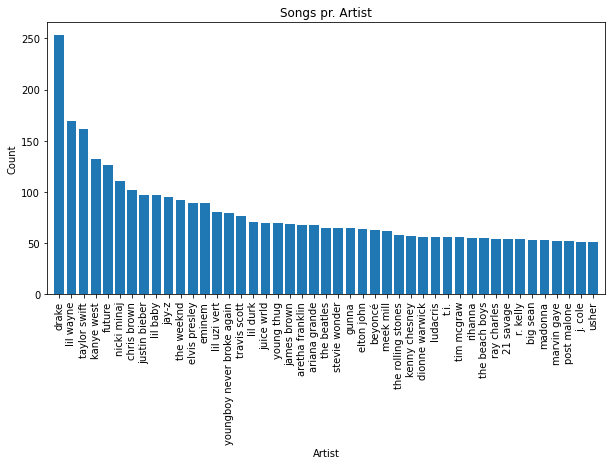

In [55]:
sorted_artists = {k: v for k, v in sorted(artist_count.items(), key=lambda item: item[1], reverse=True) if v > 50}
#for k, v in sorted_artists.items():
#    print(k + ':', v)

fig = plt.figure(figsize=(10,5))
plt.bar(*zip(*sorted_artists.items()))
plt.xlim(-1, len(sorted_artists.items()))
plt.xlabel('Artist')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Songs pr. Artist')
plt.show()

plotly_fig = tls.mpl_to_plotly(fig, resize=False)
plotly_fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(np.arange(len(sorted_artists.keys()))),
        ticktext = list(sorted_artists.keys())),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title_x =0.5,
    margin=dict(l=5, r=5, t=20, b=5)
)

plotly.write_image(plotly_fig, plotly_folder + "songs_per_artist.json")
iplot(plotly_fig)



In [56]:
all_genres = set()
genre_count = {}

for genres in song_data.genres:
    for genre in genres:
        if genre in all_genres:
            genre_count[genre] += 1
        else:
            genre_count[genre] = 1
    all_genres = all_genres.union(set(genres))
    
print("Total genres:", len(all_genres))


Total genres: 582


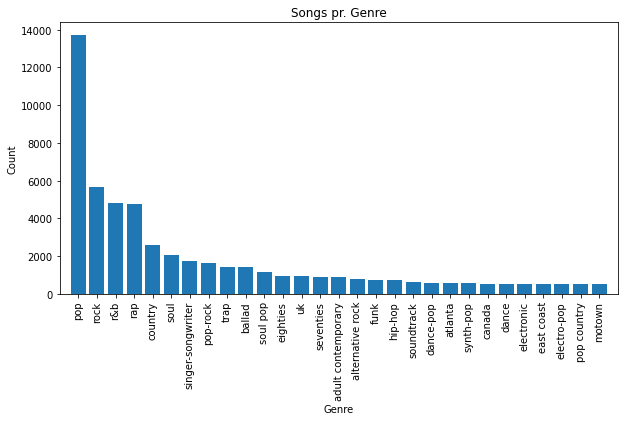

In [59]:
sorted_genres = {k: v for k, v in sorted(genre_count.items(), key=lambda item: item[1], reverse=True) if v > 500}
#for k, v in sorted_genres.items():
#    print(k + ':', v)

fig = plt.figure(figsize=(10,5))
plt.bar(*zip(*sorted_genres.items()))
plt.xlim(-1, len(sorted_genres.items()))
plt.xlabel('Genre')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Songs pr. Genre')
plt.show()

plotly_fig = tls.mpl_to_plotly(fig, resize=False)
plotly_fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(np.arange(len(sorted_genres.keys()))),
        ticktext = list(sorted_genres.keys())),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title_x =0.5,
    margin=dict(l=5, r=5, t=20, b=5)
)

plotly.write_image(plotly_fig, plotly_folder + "songs_per_genre.json")
iplot(plotly_fig)

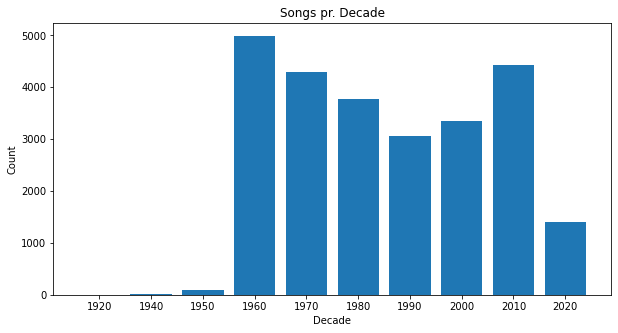

In [60]:
decade_count = defaultdict(lambda: 0)
for date in song_data.released:
    year = (int(date[:4]) // 10) * 10
    decade_count[str(year)] += 1

decade_count = {k: v for k, v in sorted(decade_count.items(), key=lambda item: int(item[0])) if v > 1}

fig = plt.figure(figsize=(10,5))
plt.bar(*zip(*decade_count.items()))
plt.xlabel('Decade')
plt.ylabel('Count')
plt.title('Songs pr. Decade')
plt.show()

plotly_fig = tls.mpl_to_plotly(fig, resize=False)
plotly_fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(np.arange(len(decade_count.keys()))),
        ticktext = list(decade_count.keys())),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title_x =0.5,
    margin=dict(l=5, r=5, t=20, b=5)
)

plotly.write_image(plotly_fig, plotly_folder + "songs_per_decade.json")
iplot(plotly_fig)

### Characteristics of the data
The data has now been gathered and thoroughly cleaned, but before we are ready to apply our network science and text analysing techniques to it, we will first look at [_the ten characteristics of Big Data_](https://www.bitbybitbook.com/en/1st-ed/observing-behavior/characteristics/):

> ### Big

As mentioned previously, the data set comprises 25,419 songs and 7,855 unique artists, but in addition, the lyric corpus has a total size of 8,476,446 with 74,915 unique tokens. With this type of information, a data set of this size would be tough to come by other than scraping the internet.


> ### Always-on

Billboard updates their 'The Hot 100' chart each week, which means the list has been updated since we first collected the data. Because it updates each week, the data set can be updated 52 times a year, which makes the data longitudinal, but since it updates only 52 times a year and not constantly like, e.g. Twitter, it is not entirely _always-on_.

> ### Non-reactive

Reactivity describes whether subjects know researchers are observing them because that might change the subjects' behaviour. All musical artists are most likely aware that they are present on the chart and might follow their ranking closely, but the question is how much they change their behaviour and musical style to get a higher ranking on the chart. One could speculate that some artists might change their use of words and language to appeal to a broader audience to perform better on the chart, while others follow their musical heart. Though, with this being said, we do not believe that the fact that researchers might also be looking at the chart with the intent to do network science and text analysis will change the behaviour of the artists.

> ### Incomplete

Completeness express if the data set manages to capture the entire unfolding of a specific event or, e.g., the entire network of a specific group. In the case of this project, we are attempting to analyse the network and text of the most popular artists and songs through modern time. With this in mind, we believe that using Billboard's 'The Hot 100' chart gives a good indication of the most popular artists and songs, though arguments could be made for the case that the chart might be skewed towards music popular in the states.


> ### Inaccessable

The data used in this project is very much accessible. As was accounted for earlier on this page, everything has been downloaded freely off the internet via different APIs.

> ### Nonrepresentative

Representativity denotes whether the data can generalise to, e.g., social phenomena more in general - out-of-sample generalisation. To this end, being a musician is quite a unique occupation when it comes to a social network of collaboration, in comparison to, e.g. a profession like acting. One could presume the typical actor is more connected than the typical musician since many actors are associated with a movie or tv-show, while often not many musicians are working on a song. At least not many musicians are seen shown as the artists on a given song, while many people might have worked on it during the songwriting and musical production.
Additionally, since our data set only contains songs in English from a popular music chart in the west, the data might not be suited for generalisation of the network, or text, for musicians from other parts of the planet. With this being said, the data set is probably still perfectly applicable for within-sample comparisons.

> ### Drifting

There is some systemic drifting in the data set, as the way songs were picked for the 'Hot-100' list has changed since its inception back in 1958. Originally, songs were picked purely based on how well they sold, but as the music industry evolved and radio, tv and streaming started becoming more prevalent, all these factors are now considered, when songs are picked for the list.

> ### Algorithmically confounded

As the songs are only picked from the Billboard 'Hot-100' list, there is some amount of algorithmic confounding going on.

> ### Dirty

The data set could be dirty as some songs could still be loaded wrongly, or we might have missed something via the cleaning. Furthermore, the data is not a complete overview of the connections between artists or the language they use, as we only chose songs that appeared on the 'Hot-100' list.

> ### Sensitive

The data is not sensitive, as there is no information in it, that isn't already public, as well as the data just being very basic stats, release year, song title, song artists.